## **How to run a CUDA code on GOOGLE COLAB**


Para pasar las cosas a CUDA es necesario ver en el algoritmo las partes que necesitan repetirse vairas veces, ya que estas las vamos a correr en la gráfica. En nuestro tenemos lo siguiente

![image.png](attachment:image.png)

En base a lo anterior se va estructurar el codigo de LBWaves.

1. In the execution menu choice the GPU acceleration option

2. The next lines verify if a GPU was assigned

In [1]:
# Show if a CUDA Toolkit was installed
!ls /usr/local
# Show it the  nvcc command can be called
!which nvcc
# Show which NVIDIA card was assigned
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

bin    cuda	cuda-12.2  games	       include	lib64	   man	 share
colab  cuda-12	etc	   _gcs_config_ops.so  lib	licensing  sbin  src
/usr/local/cuda/bin/nvcc
Tue May 28 14:47:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
| 

3. Just paste your code below the line
%%writefile RunCode.cu

In [13]:
#Escribe el archivo .cu que se vaya a utilizar

%%writefile LBM_Ondas2D_D2Q5_CUDA.cu
#include  <iostream>
#include  <cmath>
#include <omp.h>
#include  <fstream>

using namespace std;

//-------------------------------CONSTANTES GLOBALES------------------------
#define Lx 128
#define Ly 128
#define N 32 //Threads per Block
const int M=(Lx*Ly+N-1)/N; //Blocks per Grid
#define Q 5
const int ArraySize=Lx*Ly*Q;

const float W0=1.0/3;

const float C=0.5; // C<0.707 cells/click
const float C2=C*C;
const float AUX0=1-3*C2*(1-W0);

const float tau=0.5;
const float Utau=1.0/tau;
const float UmUtau=1-Utau;

//---------------- PROGRAMING ON THE DEVICE ------------

//------------------Constants (Symbols) -------------------
__constant__ float d_w[Q];
__constant__ int d_Vx[Q];
__constant__ int d_Vy[Q];
__constant__ float d_C[3];   // d_C[0]=C,  d_C[1]=C2,  d_C[2]=AUX,
__constant__ float d_tau[3];  // d_tau[0]=tau,  d_tau[1]=Utau,  d_tau[2]=UmUtau,

//----------Functions called by the device itself (__device__)
//data index
__device__ int d_n(int ix,int iy,int i){
  return (ix*Ly+iy)*Q+i;
}

//macroscopic fields
__device__ float d_rho(int ix,int iy,float *d_f){
  float sum; int i,n0;
  for(sum=0,i=0;i<Q;i++){
    n0=d_n(ix,iy,i); sum+=d_f[n0];
  }
  return sum;
}
__device__ float d_Jx(int ix,int iy,float *d_f){
  float sum; int i,n0;
  for(sum=0,i=0;i<Q;i++){
    n0=d_n(ix,iy,i); sum+=d_Vx[i]*d_f[n0];
  }
  return sum;
}
__device__ float d_Jy(int ix,int iy,float *d_f){
  float sum; int i,n0;
  for(sum=0,i=0;i<Q;i++){
    n0=d_n(ix,iy,i); sum+=d_Vy[i]*d_f[n0];
  }
  return sum;
}
//equilibrium functions
__device__ float d_feq(float rho0,float Jx0,float Jy0,int i){
  return 3*d_w[i]*(d_C[1]*rho0+d_Vx[i]*Jx0+d_Vy[i]*Jy0);
}
__device__ float d_f0eq(float rho0,float Jx0,float Jy0){
  return rho0*d_C[2];
}
//---------------------KERNELS----------------------------
__global__ void d_Collision(float *d_f,float *d_fnew){
  //Define internal registers
  int icell,ix,iy,i,n0;  float rho0,Jx0,Jy0;
  //Find which thread an which cell should I work
  icell=blockIdx.x*blockDim.x+threadIdx.x;
  ix=icell/Ly; iy=icell%Ly;
  //Compute the macroscopic fields
  rho0=d_rho(ix,iy,d_f); //rho
  Jx0=d_Jx(ix,iy,d_f);   //Jx0
  Jy0=d_Jy(ix,iy,d_f);   //Jy0
  //Collide and compute fnew
  n0=d_n(ix,iy,0); d_fnew[n0]=d_tau[2]*d_f[n0]+d_tau[1]*d_f0eq(rho0,Jx0,Jy0);
  for(i=1;i<Q;i++){ //on each direction
    n0=d_n(ix,iy,i); d_fnew[n0]=d_tau[2]*d_f[n0]+d_tau[1]*d_feq(rho0,Jx0,Jy0,i);
  }
}
__global__ void d_ImposeFields(float *d_f,float *d_fnew,float RhoSource){
  //Define internal registers
  int ix,iy,i,n0;  float rho0,Jx0,Jy0;
  //There is only one thread and for one cell in the center
  ix=Lx/2; iy=Ly/2;
  //Compute the macroscopic fields
  rho0=RhoSource; //rho
  Jx0=d_Jx(ix,iy,d_f);   //Jx0
  Jy0=d_Jy(ix,iy,d_f);   //Jy0
  //Collide and compute fnew
  n0=d_n(ix,iy,0); d_fnew[n0]=d_f0eq(rho0,Jx0,Jy0);
  for(i=1;i<Q;i++){ //on each direction
    n0=d_n(ix,iy,i); d_fnew[n0]=d_feq(rho0,Jx0,Jy0,i);
  }
}
__global__ void d_Advection(float *d_f,float *d_fnew){
  //Define internal registers
  int icell,ix,iy,i,ixnext,iynext,n0,n0next;
  //Find which thread an which cell should I work
  icell=blockIdx.x*blockDim.x+threadIdx.x;
  ix=icell/Ly; iy=icell%Ly;
  //Move the contents to the neighboring cells
  for(i=0;i<Q;i++){ //on each direction
    ixnext=(ix+d_Vx[i]+Lx)%Lx; iynext=(iy+d_Vy[i]+Ly)%Ly;//periodic boundaries
    n0=d_n(ix,iy,i); n0next=d_n(ixnext,iynext,i);
    d_f[n0next]=d_fnew[n0];
  }
}
//--------------------- class LatticeBoltzmann ------------

class LatticeBoltzmann{
private:
    float h_C[3];   // h_C[0]=C,  h_C[1]=C2,  h_C[2]=AUX,
    float h_tau[3]; // h_tau[0]=tau,  h_tau[1]=Utau,  h_tau[2]=UmUtau,
    float h_w[5]; // w[i]
    int h_Vx[5],h_Vy[5]; // Vx[i],Vy[i]
    float *h_f,*h_fnew;  float *d_f,*d_fnew;// f[ix][iy][i]
    float *h_Test,*d_Test; //Just for tests
public:
    LatticeBoltzmann(void);
    ~LatticeBoltzmann(void);
    int h_n(int ix,int iy,int i){return (ix*Ly+iy)*Q+i;};
    float h_rho(int ix,int iy);
    float h_Jx(int ix,int iy);
    float h_Jy(int ix,int iy);
    float h_feq(float rho0,float Jx0,float Jy0,int i);
    void Start(float rho0,float Jx0,float Jy0);
    void Collision(void);
    void ImposeFields(int t);
    void Advection(void);
    void Print(const char * NameFile);
};
//------------ PROGRAMMING ON THE HOST ----------------
//---------------------Constructor---------------------
LatticeBoltzmann::LatticeBoltzmann(void){
  //CONSTANTS(d_Symbols)
  //---Charge constantes on the Host-----------------
  //running constants
  h_C[0]=C;  h_C[1]=C2;  h_C[2]=AUX0;
  h_tau[0]=tau;  h_tau[1]=Utau;  h_tau[2]=UmUtau;
  //weights
  h_w[0]=W0; h_w[1]=h_w[2]=h_w[3]=h_w[4]=(1.0-W0)/4;
  //velocity vectors
  h_Vx[0]=0;  h_Vx[1]=1;  h_Vx[2]=0;  h_Vx[3]=-1; h_Vx[4]=0;
  h_Vy[0]=0;  h_Vy[1]=0;  h_Vy[2]=1;  h_Vy[3]=0;  h_Vy[4]=-1;

  //------Send to the Device-----------------

  cudaMemcpyToSymbol(d_w,h_w,Q*sizeof(float),0,cudaMemcpyHostToDevice);
  cudaMemcpyToSymbol(d_Vx,h_Vx,Q*sizeof(int),0,cudaMemcpyHostToDevice);
  cudaMemcpyToSymbol(d_Vy,h_Vy,Q*sizeof(int),0,cudaMemcpyHostToDevice);
  cudaMemcpyToSymbol(d_C,h_C,3*sizeof(float),0,cudaMemcpyHostToDevice);
  cudaMemcpyToSymbol(d_tau,h_tau,3*sizeof(float),0,cudaMemcpyHostToDevice);

  //DISTRIBUTION FUNCTIONS
  //Build the dynamic matrices on the host
  h_f=new float [ArraySize];  h_fnew=new float [ArraySize];
  //Build the dynamic matrices on the device
  cudaMalloc((void**) &d_f,ArraySize*sizeof(float));
  cudaMalloc((void**) &d_fnew,ArraySize*sizeof(float));
  //Test variables
   h_Test=new float [1]; cudaMalloc((void**) &d_Test,sizeof(float));
}

//---------------------Destructor---------------------
LatticeBoltzmann::~LatticeBoltzmann(void){
    delete[] h_f;  delete[] h_fnew;
    cudaFree(d_f);  cudaFree(d_fnew);
}

//---------------------Campos macroscópicos---------------------
float LatticeBoltzmann::h_rho(int ix,int iy){
  //Note: Please import data from device before running
  float sum; int i,n0;
  for(sum=0,i=0;i<Q;i++){
    n0=h_n(ix,iy,i); sum+=h_fnew[n0];
  }
  return sum;
}
float LatticeBoltzmann::h_Jx(int ix,int iy){
  //Note: Please import data from device before running
  float sum; int i,n0;
  for(sum=0,i=0;i<Q;i++){
    n0=h_n(ix,iy,i); sum+=h_Vx[i]*h_fnew[n0];
  }
  return sum;
}
float LatticeBoltzmann::h_Jy(int ix,int iy){
  //Note: Please import data from device before running
  float sum; int i,n0;
  for(sum=0,i=0;i<Q;i++){
    n0=h_n(ix,iy,i); sum+=h_Vy[i]*h_fnew[n0];
  }
  return sum;
}

//---------------------Función de equilibrio---------------------
float  LatticeBoltzmann::h_feq(float rho0,float Jx0,float Jy0,int i){
  if(i>0)
    return 3*h_w[i]*(C2*rho0+h_Vx[i]*Jx0+h_Vy[i]*Jy0);
  else
    return rho0*AUX0;
}

//---------------------Evolución temporal---------------------
void LatticeBoltzmann::Start(float rho0,float Jx0,float Jy0){
  //Charge on the Host
  int ix,iy,i,n0;
  for(ix=0;ix<Lx;ix++) //for each cell
    for(iy=0;iy<Ly;iy++)
      for(i=0;i<Q;i++){ //on each direction
	n0=h_n(ix,iy,i); h_f[n0]=h_feq(rho0,Jx0,Jy0,i);
      }
  //Send to the Device
  cudaMemcpy(d_f,h_f,ArraySize*sizeof(float),cudaMemcpyHostToDevice);
}

//---------------------Reglas de evolución---------------------
void LatticeBoltzmann::Collision(void){
  //Do everything on the Device
  dim3 ThreadsPerBlock(N,1,1);
  dim3 BlocksPerGrid(M,1,1);
  d_Collision<<<BlocksPerGrid,ThreadsPerBlock>>>(d_f,d_fnew);
}

void LatticeBoltzmann::ImposeFields(int t){
  float lambda=10, omega=2*M_PI/lambda*C;
  float RhoSource=10*sin(omega*t);
  dim3 ThreadsPerBlock(1,1,1); //A single thread (in this case)
  dim3 BlocksPerGrid(1,1,1);
  d_ImposeFields<<<BlocksPerGrid,ThreadsPerBlock>>>(d_f,d_fnew,RhoSource);
}

void LatticeBoltzmann::Advection(void){
  //Do everything on the Device
  dim3 ThreadsPerBlock(N,1,1);
  dim3 BlocksPerGrid(M,1,1);
  d_Advection<<<BlocksPerGrid,ThreadsPerBlock>>>(d_f,d_fnew);
}


//---------------------Impresión de resultados---------------------
void LatticeBoltzmann::Print(const char * NameFile){
  ofstream MyFile(NameFile); float rho0; int ix,iy;
  //Bring back the data from Device to Host
  cudaMemcpy(h_fnew,d_fnew,ArraySize*sizeof(float),cudaMemcpyDeviceToHost);
  //Print for gnuplot splot
  for(ix=0;ix<Lx;ix++){
    for(iy=0;iy<Ly;iy++){
      rho0=h_rho(ix,iy);
      MyFile<<ix<<" "<<iy<<" "<<rho0<<endl;
    }
    MyFile<<endl;
  }
  MyFile.close();
}

//---------------MAIN-----------------

int main(void){
  LatticeBoltzmann Waves;

  //Simulation parameters
  double t,tmax=100;
  double rho0=0,Jx0=0,Jy0=0;

  //Start the simulation
  Waves.Start(rho0,Jx0,Jy0);

  //Run the simulation
  // #pragma omp parallel
  for(t=0;t<tmax;t++){
    Waves.Collision();
    Waves.ImposeFields(t);
    Waves.Advection();
    // clog<<"\nPorcentaje de avance: "<<(t/tmax)*100<<"%"<<endl;
  }

  //Print the results
  Waves.Print("Ondas.dat");

  return 0;
}

Overwriting LBM_Ondas2D_D2Q5_CUDA.cu


4. Let us compile the .cu code with nvcc

Notes:
*   The flags are necessary if the GPU is a NVIDIA K80 card.
*   The output archive "Waves_CUDA.dat" will appear in the directory on the left

In [14]:
%%shell
time nvcc -arch=sm_75 -gencode=arch=compute_75,code=sm_75 LBM_Ondas2D_D2Q5_CUDA.cu -o Ejecutar
./Ejecutar


real	0m2.617s
user	0m1.542s
sys	0m0.403s


In [16]:
!ls

Ejecutar  LBM_Ondas2D_D2Q5_CUDA.cu  LBM_Ondas2D_D2Q5_EnCUDA.cu	Ondas.dat  sample_data


<function matplotlib.pyplot.show(close=None, block=None)>

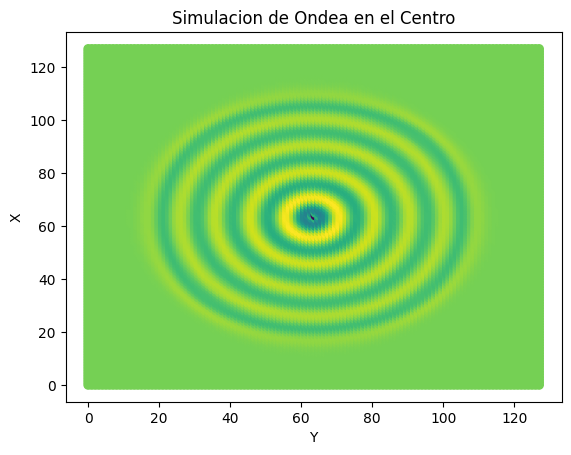

In [18]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("Ondas.dat")
x, y, rho = data[:,0] , data[:,1] , data[:,2]
plt.scatter(x,y,c=rho, cmap='viridis')
plt.ylabel("X")
plt.xlabel("Y")
plt.title("Simulacion de Ondea en el Centro")
plt.show



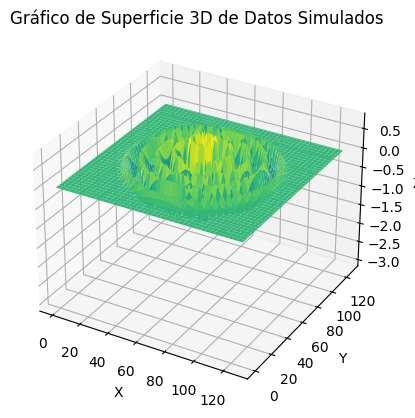

In [19]:
# Convertir datos a una malla cuadrada
Lx = int(np.max(x)) + 1
Ly = int(np.max(y)) + 1
X, Y = np.meshgrid(np.arange(Lx), np.arange(Ly))
Rho = rho.reshape((Lx, Ly))

# Crear una figura
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Dibujar la superficie
ax.plot_surface(X, Y, Rho, cmap='viridis')

# Añadir etiquetas
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Gráfico de Superficie 3D de Datos Simulados')

# Mostrar el gráfico
plt.show()